In [1]:

# %% [markdown]
# # Two-stage "criticality cascade" model (CIS 5200 final)
# 
# Stage 1: cost-sensitive logistic regression (high recall)
# Stage 2: random forest on "maybe critical" VMs (improve precision)
# 
# Features: ONLY arrival-time columns (23) from README, excluding IDs.

# %%
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer   # <-- add this
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

RANDOM_STATE = 520
np.random.seed(RANDOM_STATE)

DATA_PATH = "../data_final/vm_request_table_with_split.parquet"


In [2]:
# %% [markdown]
# ## Load final dataset and restrict to arrival-time features

# %%
# Load with Polars (fast)
df_pl = pl.read_parquet(DATA_PATH)

print("Columns:", len(df_pl.columns))
print("Rows:", df_pl.height)

# Sanity check the splits
print(df_pl["split"].value_counts())
print(df_pl["critical"].value_counts())

# %%
# Arrival-time columns we are allowed to use for an incoming VM.
# These are exactly the non-ID features in the README's "Features we HAVE at arrival time":
arrival_feature_cols = [
    "ts_vm_created",
    "day_idx",
    "hour_of_day",
    "vm_category",
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    "ts_first_vm_created",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour",
    "hist_n_vms",
    "hist_n_critical",
    "hist_has_past",
    "hist_critical_frac",
    "hist_lifetime_mean",
    "hist_lifetime_std",
    "hist_cpu_mean_mean",
    "hist_p95_mean",
    "hist_frac_gt60_mean",
    "hist_day_night_ratio_mean",
]

# Sanity: make sure all of these exist in the table
missing = [c for c in arrival_feature_cols if c not in df_pl.columns]
assert not missing, f"Missing expected arrival-time cols: {missing}"

# We'll drop IDs and any post-hoc columns implicitly by selecting only the list above.
label_col = "critical"
split_col = "split"

# Convert split slices to pandas for sklearn
train_pl = df_pl.filter(pl.col(split_col) == "train")
val_pl   = df_pl.filter(pl.col(split_col) == "val")
test_pl  = df_pl.filter(pl.col(split_col) == "test")

train = train_pl.select(arrival_feature_cols + [label_col]).to_pandas()
val   = val_pl.select(arrival_feature_cols + [label_col]).to_pandas()
test  = test_pl.select(arrival_feature_cols + [label_col]).to_pandas()

print("Train shape:", train.shape)
print("Val shape:  ", val.shape)
print("Test shape: ", test.shape)

# %%
X_train = train[arrival_feature_cols]
y_train = train[label_col].astype(int).values

X_val = val[arrival_feature_cols]
y_val = val[label_col].astype(int).values

X_test = test[arrival_feature_cols]
y_test = test[label_col].astype(int).values

print("Positive rate (critical=1):")
for name, y in [("train", y_train), ("val", y_val), ("test", y_test)]:
    print(f"{name:5s}: {y.mean():.4f}")


Columns: 73
Rows: 894280
shape: (3, 2)
┌───────┬────────┐
│ split ┆ count  │
│ ---   ┆ ---    │
│ str   ┆ u32    │
╞═══════╪════════╡
│ train ┆ 632426 │
│ test  ┆ 131849 │
│ val   ┆ 130005 │
└───────┴────────┘
shape: (2, 2)
┌──────────┬────────┐
│ critical ┆ count  │
│ ---      ┆ ---    │
│ i8       ┆ u32    │
╞══════════╪════════╡
│ 1        ┆ 309292 │
│ 0        ┆ 584988 │
└──────────┴────────┘
Train shape: (632426, 24)
Val shape:   (130005, 24)
Test shape:  (131849, 24)
Positive rate (critical=1):
train: 0.3593
val  : 0.3029
test : 0.3237


In [3]:
# %% [markdown]
# ## Preprocessing and metric utilities
# 
# * One-hot encode `vm_category`
# * Impute missing values
# * Standard-scale numeric features
# * Helper functions to choose thresholds and evaluate cascade

# %%
categorical_features = ["vm_category"]
numeric_features = [c for c in arrival_feature_cols if c not in categorical_features]

# Categorical: impute then one-hot
cat_imputer = SimpleImputer(strategy="most_frequent")

# Handle sklearn version differences (sparse vs sparse_output)
try:
    ohe = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False,  # sklearn >= 1.2
    )
except TypeError:
    ohe = OneHotEncoder(
        handle_unknown="ignore",
        sparse=False,         # older sklearn versions
    )

categorical_transformer = Pipeline(
    steps=[
        ("imputer", cat_imputer),
        ("ohe", ohe),
    ]
)

# Numeric: median imputation + scaling
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ]
)

# %%
def precision_recall_f1(y_true, y_pred):
    """Return (precision, recall, f1) for positive class 1."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (
        2 * precision * recall / (precision + recall)
        if (precision + recall) > 0
        else 0.0
    )
    return precision, recall, f1


def choose_t1_for_target_recall(y_true, p_hat, target_recall=0.98):
    """
    Stage-1 threshold: find t1 with recall >= target_recall,
    and among those, choose the one with best precision.
    If none reach target recall, choose the one with best recall (ties by precision).
    """
    y_true = np.asarray(y_true)
    p_hat = np.asarray(p_hat)

    thresholds = np.linspace(0.01, 0.8, 80)
    best_t = 0.5
    best_prec = -1.0
    best_rec = -1.0
    best_f1 = -1.0
    best_meets_target = False

    for t in thresholds:
        y_pred = (p_hat >= t).astype(int)
        prec, rec, f1 = precision_recall_f1(y_true, y_pred)

        meets_target = rec >= target_recall
        if meets_target:
            # prioritize constraints: recall >= target, then precision
            if (not best_meets_target) or (prec > best_prec):
                best_meets_target = True
                best_t, best_prec, best_rec, best_f1 = t, prec, rec, f1
        else:
            # if target never met, fall back to max recall, then precision
            if (not best_meets_target) and (rec > best_rec or (rec == best_rec and prec > best_prec)):
                best_t, best_prec, best_rec, best_f1 = t, prec, rec, best_f1

    return best_t, best_prec, best_rec, best_f1


def choose_best_f1_threshold(y_true, p_hat, num_grid=80, lo=0.05, hi=0.95):
    """Stage-2 threshold: sweep and pick t2 that maximizes F1 for class 1."""
    y_true = np.asarray(y_true)
    p_hat = np.asarray(p_hat)

    thresholds = np.linspace(lo, hi, num_grid)
    best_t = 0.5
    best_prec = 0.0
    best_rec = 0.0
    best_f1 = 0.0

    for t in thresholds:
        y_pred = (p_hat >= t).astype(int)
        prec, rec, f1 = precision_recall_f1(y_true, y_pred)
        if f1 > best_f1:
            best_t, best_prec, best_rec, best_f1 = t, prec, rec, f1

    return best_t, best_prec, best_rec, best_f1


In [4]:
# %% [markdown]
# ## Stage 1: Cost-sensitive logistic regression
# 
# Goal: very high recall on criticals, accept more false positives.

# %%
stage1_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "logreg",
            LogisticRegression(
                penalty="l2",
                C=1.0,
                class_weight="balanced",  # cost-sensitive for rare positives
                solver="liblinear",
                max_iter=1000,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

stage1_clf.fit(X_train, y_train)

# %%
# Probabilities for positive class
p_train_stage1 = stage1_clf.predict_proba(X_train)[:, 1]
p_val_stage1   = stage1_clf.predict_proba(X_val)[:, 1]
p_test_stage1  = stage1_clf.predict_proba(X_test)[:, 1]

# Baseline Stage-1 metrics with default threshold 0.5 (just for reference)
y_val_stage1_05 = (p_val_stage1 >= 0.5).astype(int)
print("Stage 1 (threshold=0.5) on VAL")
print(confusion_matrix(y_val, y_val_stage1_05))
print(classification_report(y_val, y_val_stage1_05, digits=4))

# %%
# Choose t1 on validation data to hit high recall on criticals
TARGET_RECALL_STAGE1 = 0.98

t1, prec1, rec1, f1_1 = choose_t1_for_target_recall(
    y_true=y_val,
    p_hat=p_val_stage1,
    target_recall=TARGET_RECALL_STAGE1,
)

print(f"Chosen Stage-1 threshold t1 = {t1:.3f}")
print(f"VAL Stage-1 metrics at t1:")
y_val_stage1 = (p_val_stage1 >= t1).astype(int)
print(confusion_matrix(y_val, y_val_stage1))
print(classification_report(y_val, y_val_stage1, digits=4))
print(f"(prec={prec1:.4f}, rec={rec1:.4f}, f1={f1_1:.4f})")

# %%
# We'll also inspect train performance at t1 (just to see overfitting)
y_train_stage1 = (p_train_stage1 >= t1).astype(int)
print("Stage 1 on TRAIN at t1")
print(confusion_matrix(y_train, y_train_stage1))
print(classification_report(y_train, y_train_stage1, digits=4))


Stage 1 (threshold=0.5) on VAL
[[80196 10432]
 [15122 24255]]
              precision    recall  f1-score   support

           0     0.8414    0.8849    0.8626     90628
           1     0.6993    0.6160    0.6550     39377

    accuracy                         0.8034    130005
   macro avg     0.7703    0.7504    0.7588    130005
weighted avg     0.7983    0.8034    0.7997    130005

Chosen Stage-1 threshold t1 = 0.140
VAL Stage-1 metrics at t1:
[[15094 75534]
 [  688 38689]]
              precision    recall  f1-score   support

           0     0.9564    0.1665    0.2837     90628
           1     0.3387    0.9825    0.5038     39377

    accuracy                         0.4137    130005
   macro avg     0.6476    0.5745    0.3937    130005
weighted avg     0.7693    0.4137    0.3504    130005

(prec=0.3387, rec=0.9825, f1=0.5038)
Stage 1 on TRAIN at t1
[[ 50484 354703]
 [  2603 224636]]
              precision    recall  f1-score   support

           0     0.9510    0.1246    0.2

In [5]:
# %% [markdown]
# ## Precompute preprocessed feature matrices for Stage 2

# %%
# Get fitted preprocessor from Stage-1 pipeline
fitted_preprocess = stage1_clf.named_steps["preprocess"]

X_train_pre = fitted_preprocess.transform(X_train)
X_val_pre   = fitted_preprocess.transform(X_val)
X_test_pre  = fitted_preprocess.transform(X_test)

print("Preprocessed feature shapes:")
print("X_train_pre:", X_train_pre.shape)
print("X_val_pre:  ", X_val_pre.shape)
print("X_test_pre: ", X_test_pre.shape)

# %%
# Candidate sets: VMs that Stage 1 thinks "might be critical" (p >= t1)
cand_mask_train = p_train_stage1 >= t1
cand_mask_val   = p_val_stage1 >= t1
cand_mask_test  = p_test_stage1 >= t1  # used only for diagnostics

print("Candidate fraction (maybe critical) at Stage 1:")
for name, mask in [
    ("train", cand_mask_train),
    ("val", cand_mask_val),
    ("test", cand_mask_test),
]:
    print(f"{name:5s}: {mask.mean():.4f}")

X_train_cand_pre = X_train_pre[cand_mask_train]
y_train_cand = y_train[cand_mask_train]

X_val_cand_pre = X_val_pre[cand_mask_val]
y_val_cand = y_val[cand_mask_val]

print("Stage-2 training set shape (candidates only):", X_train_cand_pre.shape)
print("Stage-2 val set shape (candidates only):     ", X_val_cand_pre.shape)
print("Positive rate in Stage-2 TRAIN candidates:   ", y_train_cand.mean())
print("Positive rate in Stage-2 VAL candidates:     ", y_val_cand.mean())


Preprocessed feature shapes:
X_train_pre: (632426, 25)
X_val_pre:   (130005, 25)
X_test_pre:  (131849, 25)
Candidate fraction (maybe critical) at Stage 1:
train: 0.9161
val  : 0.8786
test : 0.9177
Stage-2 training set shape (candidates only): (579339, 25)
Stage-2 val set shape (candidates only):      (114223, 25)
Positive rate in Stage-2 TRAIN candidates:    0.3877453442630308
Positive rate in Stage-2 VAL candidates:      0.3387146196475316


In [6]:
# %% [markdown]
# ## Stage 2: Random forest on candidate region
# 
# Train only on VMs with p_stage1 >= t1. Focus on improving precision.

# %%
stage2_rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=5,
    max_features=0.4,
    n_jobs=-1,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)

stage2_rf.fit(X_train_cand_pre, y_train_cand)

# %%
# Evaluate Stage-2 alone on candidate VAL subset
p_val_stage2_cand = stage2_rf.predict_proba(X_val_cand_pre)[:, 1]

t2, prec2, rec2, f1_2 = choose_best_f1_threshold(
    y_true=y_val_cand,
    p_hat=p_val_stage2_cand,
)

print(f"Chosen Stage-2 threshold t2 = {t2:.3f}")
print("Stage 2 metrics on VAL candidate subset at t2:")
y_val_stage2_cand = (p_val_stage2_cand >= t2).astype(int)
print(confusion_matrix(y_val_cand, y_val_stage2_cand))
print(classification_report(y_val_cand, y_val_stage2_cand, digits=4))
print(f"(prec={prec2:.4f}, rec={rec2:.4f}, f1={f1_2:.4f})")


Chosen Stage-2 threshold t2 = 0.494
Stage 2 metrics on VAL candidate subset at t2:
[[64078 11456]
 [13200 25489]]
              precision    recall  f1-score   support

           0     0.8292    0.8483    0.8387     75534
           1     0.6899    0.6588    0.6740     38689

    accuracy                         0.7841    114223
   macro avg     0.7596    0.7536    0.7563    114223
weighted avg     0.7820    0.7841    0.7829    114223

(prec=0.6899, rec=0.6588, f1=0.6740)


In [7]:
# %% [markdown]
# ## Final cascade: Stage 1 + Stage 2 combined
# 
# Rule:
#   if p1 < t1: predict 0 (non-critical)
#   else:       predict 1 if p2 >= t2 else 0

# %%
def cascade_predict(p1, p2, t1, t2):
    """
    p1: Stage-1 probs (array of shape [n])
    p2: Stage-2 probs (array of shape [n])
    Returns y_pred (0/1) after cascade rule.
    """
    p1 = np.asarray(p1)
    p2 = np.asarray(p2)
    assert p1.shape == p2.shape

    y_pred = np.zeros_like(p1, dtype=int)
    cand_mask = p1 >= t1
    y_pred[cand_mask] = (p2[cand_mask] >= t2).astype(int)
    return y_pred

# %%
# Compute stage-2 probabilities for ALL points (we'll only use them where p1 >= t1)
p_train_stage2_all = stage2_rf.predict_proba(X_train_pre)[:, 1]
p_val_stage2_all   = stage2_rf.predict_proba(X_val_pre)[:, 1]
p_test_stage2_all  = stage2_rf.predict_proba(X_test_pre)[:, 1]

# %%
# VAL evaluation
y_val_cascade = cascade_predict(
    p1=p_val_stage1,
    p2=p_val_stage2_all,
    t1=t1,
    t2=t2,
)

print("=== CASCADE model on VAL ===")
print(confusion_matrix(y_val, y_val_cascade))
print(classification_report(y_val, y_val_cascade, digits=4))
prec_val, rec_val, f1_val = precision_recall_f1(y_val, y_val_cascade)
print(f"VAL (critical=1): prec={prec_val:.4f}, rec={rec_val:.4f}, f1={f1_val:.4f}")

# %%
# TEST evaluation (final)
y_test_cascade = cascade_predict(
    p1=p_test_stage1,
    p2=p_test_stage2_all,
    t1=t1,
    t2=t2,
)

print("=== CASCADE model on TEST ===")
print(confusion_matrix(y_test, y_test_cascade))
print(classification_report(y_test, y_test_cascade, digits=4))
prec_test, rec_test, f1_test = precision_recall_f1(y_test, y_test_cascade)
print(f"TEST (critical=1): prec={prec_test:.4f}, rec={rec_test:.4f}, f1={f1_test:.4f}")


=== CASCADE model on VAL ===
[[79172 11456]
 [13888 25489]]
              precision    recall  f1-score   support

           0     0.8508    0.8736    0.8620     90628
           1     0.6899    0.6473    0.6679     39377

    accuracy                         0.8051    130005
   macro avg     0.7703    0.7604    0.7650    130005
weighted avg     0.8020    0.8051    0.8032    130005

VAL (critical=1): prec=0.6899, rec=0.6473, f1=0.6679
=== CASCADE model on TEST ===
[[77494 11679]
 [17290 25386]]
              precision    recall  f1-score   support

           0     0.8176    0.8690    0.8425     89173
           1     0.6849    0.5949    0.6367     42676

    accuracy                         0.7803    131849
   macro avg     0.7512    0.7319    0.7396    131849
weighted avg     0.7746    0.7803    0.7759    131849

TEST (critical=1): prec=0.6849, rec=0.5949, f1=0.6367


In [8]:
# %% [markdown]
# ## Joint threshold search for cascade on VAL
# 
# We search over (t1, t2) and pick the pair that maximizes F1 for critical=1
# subject to a minimum recall constraint.

# %%
def search_cascade_thresholds(
    p1_val,
    p2_val,
    y_val,
    t1_grid=None,
    t2_grid=None,
    min_recall=0.65,
    top_k=10,
):
    if t1_grid is None:
        t1_grid = np.linspace(0.01, 0.5, 25)   # Stage 1 threshold range
    if t2_grid is None:
        t2_grid = np.linspace(0.05, 0.95, 25)  # Stage 2 threshold range

    y_val = np.asarray(y_val)
    p1_val = np.asarray(p1_val)
    p2_val = np.asarray(p2_val)

    best_f1 = -1.0
    best_prec = 0.0
    best_rec = 0.0
    best_t1 = 0.5
    best_t2 = 0.5

    all_results = []

    for t1 in t1_grid:
        for t2 in t2_grid:
            y_pred = cascade_predict(p1_val, p2_val, t1, t2)
            prec, rec, f1 = precision_recall_f1(y_val, y_pred)
            all_results.append((t1, t2, prec, rec, f1))
            # Enforce minimum recall for criticals
            if rec >= min_recall and f1 > best_f1:
                best_f1 = f1
                best_prec = prec
                best_rec = rec
                best_t1 = t1
                best_t2 = t2

    # Sort and print top-K configs by F1 (just for inspection)
    all_results_sorted = sorted(all_results, key=lambda x: x[4], reverse=True)
    print(f"Top {top_k} (t1, t2) by F1 on VAL:")
    for i, (t1, t2, prec, rec, f1) in enumerate(all_results_sorted[:top_k]):
        print(
            f"{i+1:2d}: t1={t1:.3f}, t2={t2:.3f}  "
            f"prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}"
        )

    print("\nBest (with recall >= {:.2f}):".format(min_recall))
    print(
        f"t1={best_t1:.3f}, t2={best_t2:.3f}  "
        f"prec={best_prec:.4f}, rec={best_rec:.4f}, f1={best_f1:.4f}"
    )
    return best_t1, best_t2, best_prec, best_rec, best_f1

# %%
# Run the search on VAL
t1_new, t2_new, prec_val_new, rec_val_new, f1_val_new = search_cascade_thresholds(
    p1_val=p_val_stage1,
    p2_val=p_val_stage2_all,
    y_val=y_val,
    min_recall=0.70,  # <-- adjust this up/down depending on how aggressive you want recall
)

print("\nChosen thresholds from joint search:")
print(f"t1_new = {t1_new:.3f}, t2_new = {t2_new:.3f}")


Top 10 (t1, t2) by F1 on VAL:
 1: t1=0.010, t2=0.462  prec=0.6466, rec=0.6867, f1=0.6661
 2: t1=0.030, t2=0.462  prec=0.6466, rec=0.6867, f1=0.6661
 3: t1=0.051, t2=0.462  prec=0.6466, rec=0.6867, f1=0.6661
 4: t1=0.071, t2=0.462  prec=0.6466, rec=0.6867, f1=0.6661
 5: t1=0.092, t2=0.462  prec=0.6466, rec=0.6867, f1=0.6661
 6: t1=0.112, t2=0.462  prec=0.6466, rec=0.6867, f1=0.6661
 7: t1=0.133, t2=0.462  prec=0.6466, rec=0.6867, f1=0.6661
 8: t1=0.153, t2=0.462  prec=0.6466, rec=0.6867, f1=0.6661
 9: t1=0.173, t2=0.462  prec=0.6466, rec=0.6866, f1=0.6660
10: t1=0.194, t2=0.462  prec=0.6466, rec=0.6866, f1=0.6660

Best (with recall >= 0.70):
t1=0.296, t2=0.425  prec=0.6198, rec=0.7177, f1=0.6652

Chosen thresholds from joint search:
t1_new = 0.296, t2_new = 0.425


[Cascade Validation]
              precision    recall  f1-score   support

           0      0.868     0.809     0.837     90628
           1      0.620     0.718     0.665     39377

    accuracy                          0.781    130005
   macro avg      0.744     0.763     0.751    130005
weighted avg      0.793     0.781     0.785    130005

AUC-PR: 0.7459 | AUC-ROC: 0.8348


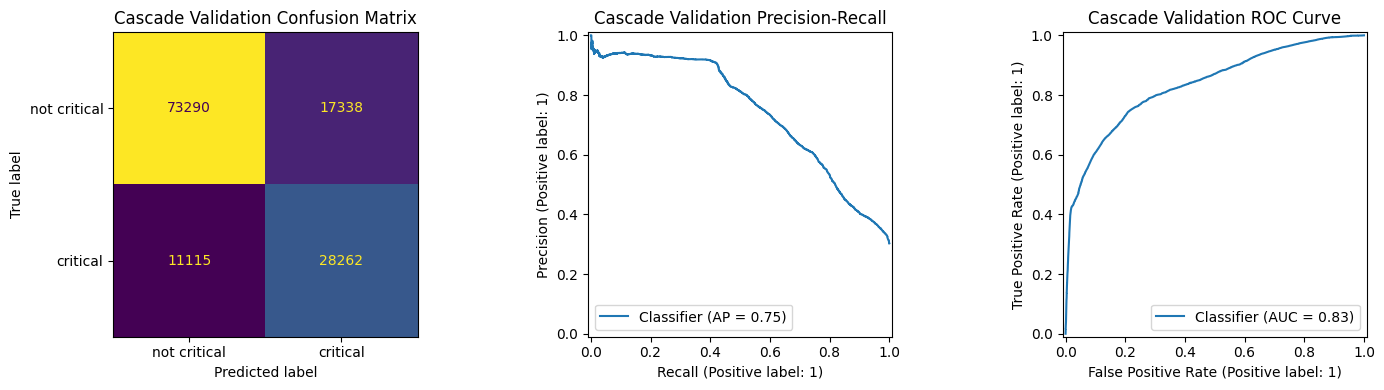

[Cascade Test]
              precision    recall  f1-score   support

           0      0.837     0.796     0.816     89173
           1      0.613     0.676     0.643     42676

    accuracy                          0.757    131849
   macro avg      0.725     0.736     0.729    131849
weighted avg      0.764     0.757     0.760    131849

AUC-PR: 0.7225 | AUC-ROC: 0.8101


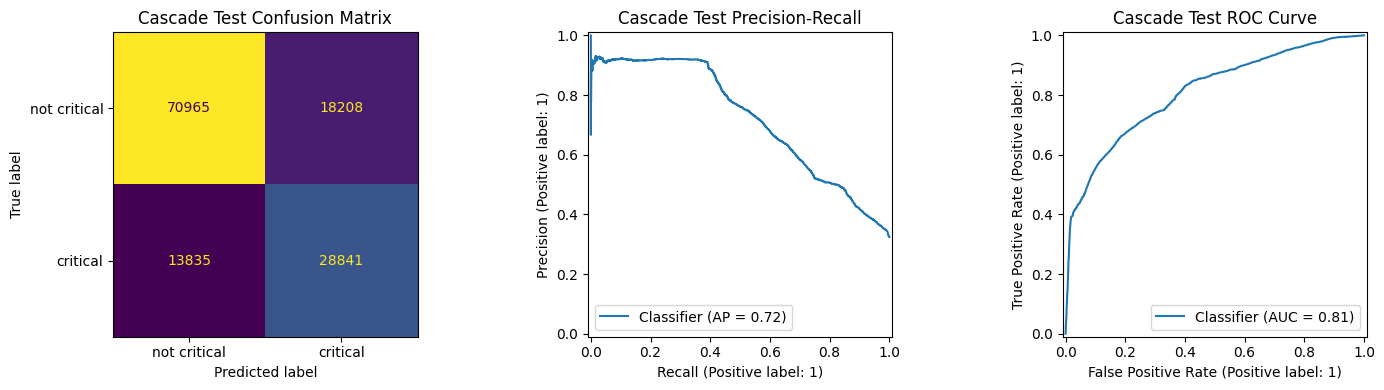

In [9]:

# %% [markdown]
# ## Re-evaluate cascade with tuned thresholds

# %%
def evaluate_split(y_true, preds, scores, split_name: str):
    pr_auc = average_precision_score(y_true, scores)
    roc_auc = roc_auc_score(y_true, scores)

    print(f"[{split_name}]")
    print(classification_report(y_true, preds, digits=3, zero_division=0))
    print(f"AUC-PR: {pr_auc:.4f} | AUC-ROC: {roc_auc:.4f}")

    cm = confusion_matrix(y_true, preds)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ConfusionMatrixDisplay(cm, display_labels=["not critical", "critical"]).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"{split_name} Confusion Matrix")
    PrecisionRecallDisplay.from_predictions(y_true, scores, ax=axes[1])
    axes[1].set_title(f"{split_name} Precision-Recall")
    RocCurveDisplay.from_predictions(y_true, scores, ax=axes[2])
    axes[2].set_title(f"{split_name} ROC Curve")
    plt.tight_layout()
    plt.show()

    return {"auc_pr": pr_auc, "auc_roc": roc_auc, "confusion": cm.tolist()}

# VAL
y_val_cascade_tuned = cascade_predict(
    p1=p_val_stage1,
    p2=p_val_stage2_all,
    t1=t1_new,
    t2=t2_new,
)
val_scores = np.where(p_val_stage1 < t1_new, p_val_stage1, p_val_stage2_all)
val_cascade_metrics = evaluate_split(y_val, y_val_cascade_tuned, val_scores, "Cascade Validation")

# TEST
y_test_cascade_tuned = cascade_predict(
    p1=p_test_stage1,
    p2=p_test_stage2_all,
    t1=t1_new,
    t2=t2_new,
)
test_scores = np.where(p_test_stage1 < t1_new, p_test_stage1, p_test_stage2_all)
test_cascade_metrics = evaluate_split(y_test, y_test_cascade_tuned, test_scores, "Cascade Test")


[Stage 1 Only (Test)]
              precision    recall  f1-score   support

           0      0.949     0.115     0.206     89173
           1      0.348     0.987     0.515     42676

    accuracy                          0.397    131849
   macro avg      0.648     0.551     0.360    131849
weighted avg      0.754     0.397     0.306    131849

AUC-PR: 0.7396 | AUC-ROC: 0.8150


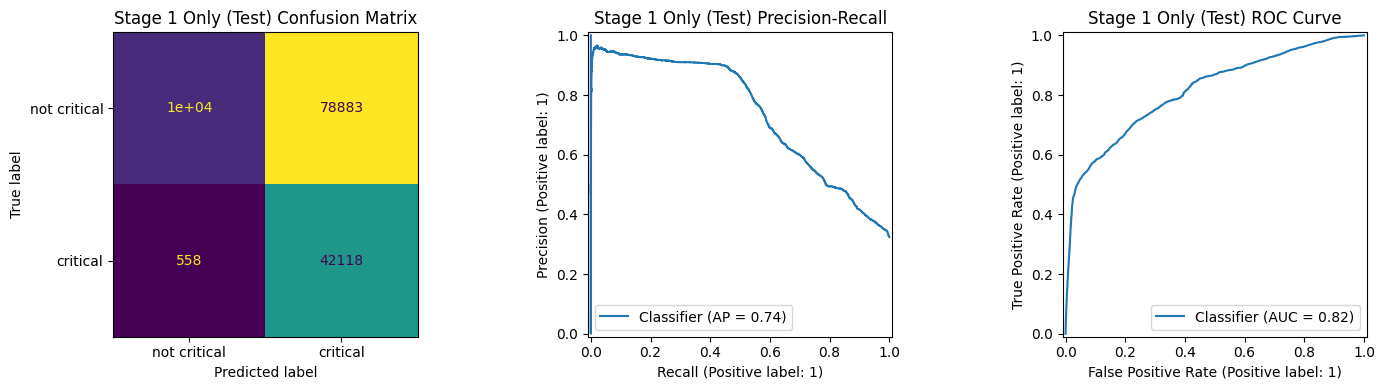

In [10]:

# %% [markdown]
# ## Optional: Compare cascade vs Stage-1-only at threshold t1

# %%
y_test_stage1_only = (p_test_stage1 >= t1).astype(int)

stage1_metrics = evaluate_split(
    y_test,
    y_test_stage1_only,
    p_test_stage1,
    "Stage 1 Only (Test)",
)

cascade_vs_stage1 = {
    "stage1_auc_pr": stage1_metrics["auc_pr"],
    "cascade_auc_pr": test_cascade_metrics["auc_pr"],
}
